In [81]:
"""
使用tensorflow构建一个三层全连接传统神经网络,作为字符识别的多分类器。通过字符图片预测对应的数字，对mnist数据集进行预测。
"""
#coding:utf8
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math
%matplotlib inline

In [82]:
mnist = input_data.read_data_sets("./mnist/",one_hot=True)

Extracting ./mnist/train-images-idx3-ubyte.gz
Extracting ./mnist/train-labels-idx1-ubyte.gz
Extracting ./mnist/t10k-images-idx3-ubyte.gz
Extracting ./mnist/t10k-labels-idx1-ubyte.gz


In [83]:
print("Training set:",mnist.train.images.shape)
print("Training set labels:",mnist.train.labels.shape)
print("Dev Set(Cross Validation set):",mnist.validation.images.shape)
print("Dev Set labels:",mnist.validation.labels.shape)
print("Test Set:",mnist.test.images.shape)
print("Test Set labels:",mnist.test.labels.shape)

Training set: (55000, 784)
Training set labels: (55000, 10)
Dev Set(Cross Validation set): (5000, 784)
Dev Set labels: (5000, 10)
Test Set: (10000, 784)
Test Set labels: (10000, 10)


In [84]:
x_train = mnist.train.images
y_train = mnist.train.labels
x_dev = mnist.validation.images
y_dev = mnist.validation.labels
x_test = mnist.test.images
y_test = mnist.test.labels

In [85]:
x_train.shape

(55000, 784)

In [86]:
def display_digit(index):
    print(y_train[index])
    label = y_train[index].argmax(axis=0)
    image = x_train[index].reshape([28,28])
    plt.title("Example: %d  Label: %d" % (index, label))
    plt.imshow(image, cmap=plt.get_cmap("gray_r"))
    plt.show()


[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


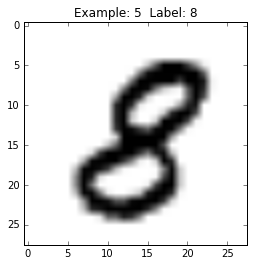

In [87]:
display_digit(5)

In [88]:
print(y_train[5].shape)

(10,)


In [93]:
#按照Andrew的建议把样本横向排列
x_train = x_train.T
y_train = y_train.T
x_dev = x_dev.T
y_dev = y_dev.T
x_test = x_test.T
y_test = y_test.T
print("x_train shape",x_train.shape)
print("y_train shape",y_train.shape)

x_train shape (784, 55000)
y_train shape (10, 55000)


In [94]:
def random_mini_batches(X,Y,mini_batch_size=64):
    """
    Creates a list of random minibatches from (X, Y)

    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer

    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    m = X.shape[1] #训练样本个数
    mini_batches = []
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((-1, m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(
        m / mini_batch_size)  # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size:(k + 1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size:(k + 1) * mini_batch_size]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, mini_batch_size * num_complete_minibatches:]
        mini_batch_Y = shuffled_Y[:, mini_batch_size * num_complete_minibatches:]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches

In [95]:
"参数初始化"
layer_dims = [784,64,128,10] #三层网络，hidden units个数为64,128，10   一共有10个类别  

In [96]:
def init_parameters(layer_dims):
    parameters = {}
    L = len(layer_dims) - 1 # number of layers in the network
    for l in range(1,L+1):
        parameters["W"+str(l)] = tf.Variable(tf.random_normal([layer_dims[l], layer_dims[l-1]]))
        parameters["b"+str(l)] = tf.Variable(tf.random_normal([layer_dims[l],1]))
    return parameters    

In [97]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    Z1 = tf.add(tf.matmul(W1, X), b1)  # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)  # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)  # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)  # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)  # Z3 = np.dot(W3,Z2) + b3

    return Z3

In [98]:
def compute_cost(Z3, Y):
    """
    Computes the cost

    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (10, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3

    Returns:
    cost - Tensor of the cost function
    """

    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    return cost

In [105]:
def tf_nn_model(X_train,Y_train,X_test,Y_test,layer_dims,learning_rate=0.001,num_epochs=100,minibatch_size=64,print_cost=True):
    (n_x,m) = X_train.shape # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0] # n_y : output size
    costs = [] # to keep track of the cost
    X = tf.placeholder(tf.float32, [n_x, None], name="X")
    Y = tf.placeholder(tf.float32, [n_y, None], name="Y")
    parameters = init_parameters(layer_dims)
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    init  = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            epoch_cost = 0.  # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size)
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _, minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                epoch_cost += minibatch_cost / num_minibatches
            if print_cost == True and epoch % 10 == 0:
                print("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)   
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show() 
        
        parameters = sess.run(parameters)
        print("Parameters have been trained!")
        
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))

        return parameters
            
    
    

Cost after epoch 0: 75.913229
Cost after epoch 10: 1.541095
Cost after epoch 20: 0.436585
Cost after epoch 30: 0.174160
Cost after epoch 40: 0.090298
Cost after epoch 50: 0.064457
Cost after epoch 60: 0.044082
Cost after epoch 70: 0.035504
Cost after epoch 80: 0.022698
Cost after epoch 90: 0.023649


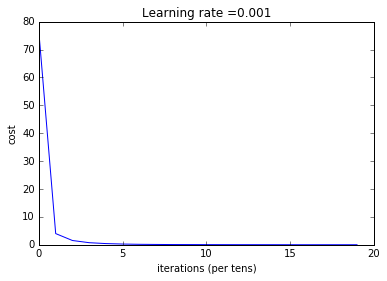

Parameters have been trained!
Train Accuracy: 0.994545
Test Accuracy: 0.9427


{'W1': array([[ 0.2372188 ,  1.27198195, -0.6455391 , ...,  1.26290512,
         -0.69059598,  0.36647785],
        [-0.50644702, -0.74370074,  0.38941762, ..., -0.15578361,
         -0.31009915, -0.17434931],
        [-2.5437634 ,  0.44527429, -0.70932513, ..., -1.01713133,
         -0.14752612,  0.19787782],
        ..., 
        [ 3.25048923,  0.08093037,  0.77567875, ..., -0.79534328,
          1.43014407,  0.21873565],
        [-1.93292856, -0.19783179,  0.12327723, ..., -0.22539552,
          0.13556184,  0.87210643],
        [-0.93210453,  0.2583403 ,  1.58626533, ..., -1.69557643,
          0.31096032,  0.41782433]], dtype=float32),
 'W2': array([[ 0.66262263, -0.41401526,  0.83104825, ..., -0.28790367,
          1.44923198, -0.01293663],
        [-0.94457793, -0.47847596,  0.39193049, ..., -0.44852871,
          0.31511024, -0.12879851],
        [ 0.83933985, -0.25525221,  1.83002853, ..., -0.7023285 ,
          0.29116887,  1.32396758],
        ..., 
        [-1.21769059,  0.

In [106]:
tf_nn_model(x_train,y_train,x_test,y_test,layer_dims,learning_rate=0.001,num_epochs=100,minibatch_size=64,print_cost=True)